In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [2]:
tf.config.experimental.list_logical_devices()

2024-06-02 10:32:16.630800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-02 10:32:16.663828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-02 10:32:16.664075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-02 10:32:16.664666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Image Processing

In [3]:
IMG_SIZE = 300
BATCH_SIZE = 16

# path_data = "./raw_data_dir/data-deon"
path_data = "./data-test"

data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path_data,
    shuffle=True,
#     color_mode="grayscale",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

classes=data.class_names
print("Class names:", classes)

Found 1300 files belonging to 25 classes.
Class names: ['benteng_vredeburg', 'candi_borobudur', 'candi_prambanan', 'garuda_wisnu_kencana', 'gedung_sate', 'istana_maimun', 'jam_gadang', 'keong_mas', 'keraton_jogja', 'kota_tua', 'lawang_sewu', 'masjid_istiqlal', 'masjid_menara_kudus', 'masjid_raya_baiturrahman', 'menara_siger_lampung', 'monas', 'monumen_bandung_lautan_api', 'monumen_gong_perdamaian', 'monumen_nol_km', 'monumen_simpang_lima_gumul', 'patung_ikan_surabaya', 'patung_yesus_memberkati', 'tugu_jogja', 'tugu_khatulistiwa', 'tugu_pahlawan_surabaya']


In [4]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

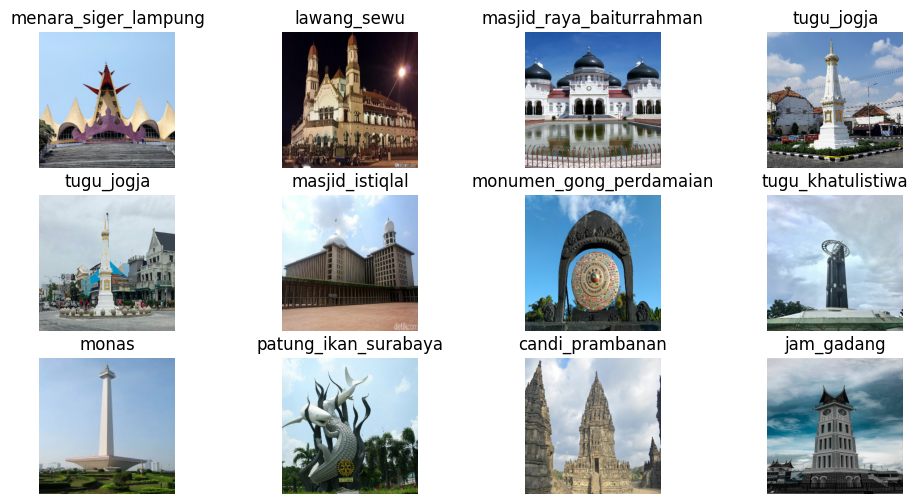

In [5]:
plt.figure(figsize=(12, 6))
for img_batch, label_batch in data.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.title(f"{classes[label_batch[i]]}")
        plt.axis("Off")
        plt.imshow(img_batch[i].numpy().astype("int"), cmap='gray');

# Splitting Data

In [6]:
len_data=len(data)

# Shuffle data
data=data.shuffle(buffer_size=10000, seed=42)

train_size=int(len_data*0.90)
# val_size=int(len_data*0.7)

train_data=data.take(train_size)
val_data=data.skip(train_size)
# test_data=data.skip(train_size).skip(val_size)

print(f"""Length of data in each batch
ori data: {len_data}
train data: {len(train_data)}
val data: {len(val_data)}
""")

Length of data in each batch
ori data: 82
train data: 73
val data: 9



# Augmenting Data

In [7]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0),
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(.13),
])

# Creating Model

In [8]:
def plot_history(model, seq_1, seq_2):
    plt.plot(model.history[seq_1], label=seq_1)
    plt.plot(model.history[seq_2], label=seq_2)
    plt.legend()
    plt.title("training history");    

## Model 1

In [9]:
IMG_SHAPE=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)

model_1 = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),    
    tf.keras.layers.Dense(25, activation="softmax"),
], name="model_1")

In [10]:
model_1.build(input_shape=IMG_SHAPE)
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 300, 300, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 298, 298, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (16, 149, 149, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 147, 147, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 73, 73, 64)         0         
 2D)                                                       

In [11]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [12]:
%%time
history_1 = model_1.fit(
    train_data,
    epochs=50,
    verbose=1,
    validation_data=val_data,
)

Epoch 1/50


2024-06-02 10:32:21.137012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


73/73 [==============================] - 19s 170ms/step - loss: 3.2181 - accuracy: 0.0424 - val_loss: 3.1172 - val_accuracy: 0.1319
Epoch 2/50
73/73 [==============================] - 13s 152ms/step - loss: 3.0183 - accuracy: 0.1107 - val_loss: 2.8118 - val_accuracy: 0.1806
Epoch 3/50
73/73 [==============================] - 13s 151ms/step - loss: 2.7925 - accuracy: 0.1825 - val_loss: 2.3606 - val_accuracy: 0.2292
Epoch 4/50
73/73 [==============================] - 13s 152ms/step - loss: 2.4801 - accuracy: 0.2457 - val_loss: 2.2720 - val_accuracy: 0.3333
Epoch 5/50
73/73 [==============================] - 13s 153ms/step - loss: 2.3045 - accuracy: 0.3166 - val_loss: 2.2144 - val_accuracy: 0.3542
Epoch 6/50
73/73 [==============================] - 13s 153ms/step - loss: 2.0666 - accuracy: 0.3867 - val_loss: 1.8267 - val_accuracy: 0.4097
Epoch 7/50
73/73 [==============================] - 13s 153ms/step - loss: 1.9410 - accuracy: 0.4377 - val_loss: 1.6818 - val_accuracy: 0.5069
Epoch 8/50

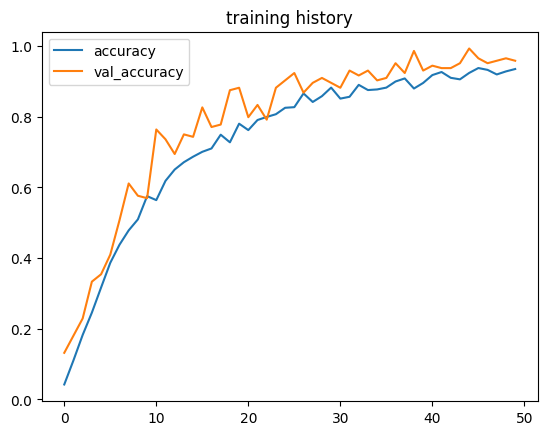

In [13]:
plot_history(history_1, "accuracy", "val_accuracy")

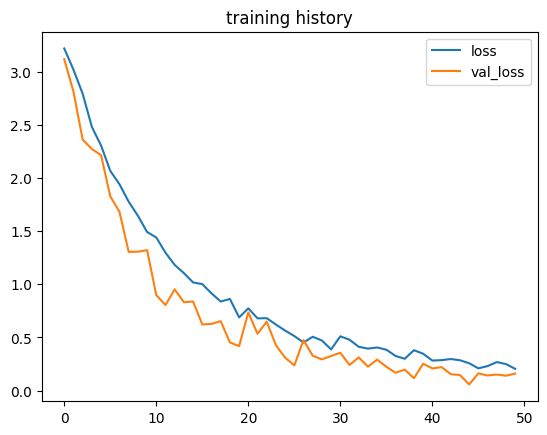

In [14]:
plot_history(history_1, "loss", "val_loss")

In [16]:
model_1.save("history/model_1.h5")